In [2]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds
from fastfusion.mapper.metrics import Metrics

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)
spec.mapper_ffm.metrics = Metrics.ENERGY | Metrics.RESOURCE_USAGE | Metrics.LATENCY
spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

# from IPython.display import SVG
# display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



INFO        Loading yaml file architecture/snowcat.arch.yaml
INFO        Found top key variables in architecture/snowcat.arch.yaml
INFO        Found top key architecture in architecture/snowcat.arch.yaml
INFO        Loading yaml file workloads/matmuls8_mixed.workload.yaml
INFO        Found top key workload in workloads/matmuls8_mixed.workload.yaml
WARNING     Loading configuration file from /root/.config/fastfusion/config.yaml
Generating tensor order and loop choices for Einsum Matmul1: 0it [00:17, ?it/s]
Generating jobs:   0%|          | 0/2 [00:17<?, ?it/s]


ValueError: Einsum Matmul1 has a mapping that is missing tensors. Ensure that there is a node storing each tensor in the Einsum. Missing tensors: {'T0', 'W1', 'T1'}. Mapping:
	

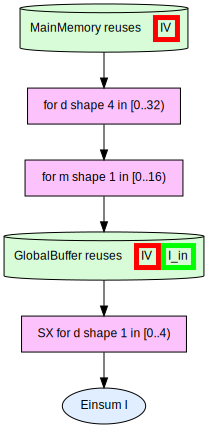

I___COMPRESSED_INDEX: 0
RESOURCE_GlobalBuffer_LEVEL_0: 32.0
RESOURCE_MainMemory_LEVEL_0: 16384
metric_Latency: 3.50228013029316
metric_Energy: 1.824768e-08
RESOURCE_LocalBuffer_LEVEL_0: 0.0
I___COMPRESSED_INDEX_x: 0
I___tile_shape0: 1.0
I___tile_shape1: 4.0
I___tile_shape2: 1.0
I___tile_shape3: 1.0
I___tile_shape4: 1.0
I___tile_shape5: 1.0
I___tile_shape6: 1.0
I___tile_shape7: 1.0
I___tile_shape8: 1.0
I_compute_Latency: 0
I_GlobalBuffer_Latency: 0.0
I_MainMemory_Latency: 3.50228013029316
I___MAPPING: type=None nodes=[Storage(type=None, tensors=['IV'], component='MainMemory', component_object=Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, technology='7nm', global_cycle_seconds=1e-09, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=1, datawidth=8, shared_read_write_bandwidth=4678.0952380952385, read_bandwidth=inf, write_bandwidth=inf, size=9999999999999, multiple_buffering=1, version='0.5', width=4678), spatial=Spatial(type=None, fanout={}), co

In [2]:
from fastfusion.mapper.FFM.visualization import make_mapping
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

i = 0
rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)
mapping = make_mapping(mappings.data.iloc[i], einsum_names=spec.workload.einsum_names, rank_variable_bounds=rank_variable_bounds)
from IPython.display import SVG
display(SVG(mapping.render()))

for col in mappings.data.columns:
    print(f"{col}: {mappings.data.iloc[i][col]}")


In [ ]:
assert False
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



AssertionError: 

In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
assert False
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



INFO        Loading yaml file architecture/snowcat.arch.yaml
INFO        Found top key variables in architecture/snowcat.arch.yaml
INFO        Found top key architecture in architecture/snowcat.arch.yaml
INFO        Loading yaml file workloads/matmuls8_mixed.workload.yaml
INFO        Found top key workload in workloads/matmuls8_mixed.workload.yaml
WARNING     Loading configuration file from /root/.config/fastfusion/config.yaml
Generating storage and loop choices for Einsum Matmul1: 20it [00:00, 158.44it/s]
Generating storage and loop choices for Einsum Matmul2: 20it [00:00, 83.82it/s]
Generating Jobs: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]
INFO        Not tracking memory MainMemory. It is big enough to hold every tensor in the workload.
INFO        Not tracking memory GlobalBuffer. It is big enough to hold every tensor in the workload.


Generated 20 jobs for Matmul1
Generated 20 jobs for Matmul2
T0
T2
W2
W1
T1


Compressing pmappings: 100%|██████████| 2/2 [00:00<00:00, 13.31it/s]


SIM Matmul1 tensors: {'T1'}
SIM Matmul2 tensors: {'T1'}


Grouping Partial Mappings: 100%|██████████| 99/99 [00:00<00:00, 1014.03it/s]


Initial consolidate and group: 0.13 seconds

Einsum Matmul2 (2/2)


Merging mappings Matmul1 <--> Matmul2: 100%|██████████| 99/99 [00:00<00:00, 586.27it/s]


Mapping merging: 0.26 seconds
	Combining 181(99) x 181(99) -> 99
	Number of groups for Einsum Matmul2: 99
	Number of mappings for Einsum Matmul2: 99
	Mappings per group for Einsum Matmul2: 1.0
	Largest left: 1
	Largest right: 1


Grouping Partial Mappings: 100%|██████████| 1/1 [00:00<00:00, 258.51it/s]



======== Total time ========
Initial consolidate and group: 0.13 seconds
Mapping merging: 0.26 seconds

Total: 0.39 seconds

Merging with shared loops 2: Matmul1 <--> Matmul2.
Merging with shared loops 2: Matmul1 <--> Matmul2.
Merging with shared loops 2: Matmul1 <--> Matmul2.
Merging with shared loops 2: Matmul1 <--> Matmul2.


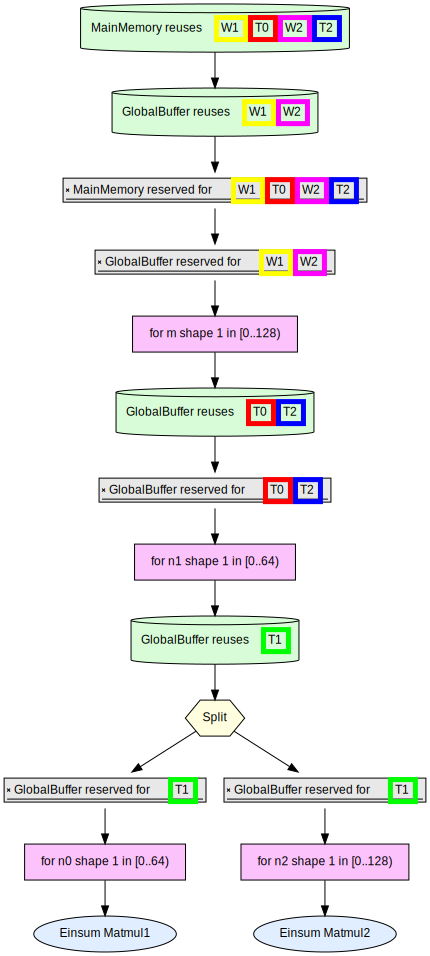

In [5]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.estimate_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.estimate_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
import importlib
import fastfusion.visualization.interactive
importlib.reload(fastfusion.visualization.interactive)
from fastfusion.visualization.interactive import plotly_show
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums
for mappings in result.values():
    mappings.make_pareto(columns=["RESOURCE_GlobalBuffer_LEVEL_0", "metric_Energy"])
result2 = {k: v.data for k, v in result.items()}
# plotly_show(result2, "RESOURCE_GlobalBuffer_LEVEL_0", "metric_Energy", category="Category", logscales=True, einsum_names=spec.workload.einsum_names, rank_variable_bounds=get_rank_variable_bounds_for_all_einsums(spec))
plotly_show(result2, "metric_Energy", "metric_Energy", category="Category", logscales=True, einsum_names=spec.workload.einsum_names, rank_variable_bounds=get_rank_variable_bounds_for_all_einsums(spec))

# from fastfusion.mapper.FFM.visualization import make_mapping
# from IPython.display import SVG
# newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
# display(SVG(newmapping.render()))

In [ ]:
from IPython.display import SVG

from fastfusion.mapper.FFM.pareto import row2pmappings
# importlib.reload(fastfusion.visualization.interactive)
# importlib.reload(fastfusion.frontend.mapping)
from fastfusion.frontend.mapping import Mapping, Fill, Reservation
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN

row = mappings.data.iloc[-1]
pmappings = row2pmappings(row, spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
    
newmapping = Mapping.from_pmappings(pmappings, rank_variable_bounds=get_rank_variable_bounds_for_all_einsums(spec)).clear_nodes_of_type(Fill)
display(SVG(newmapping.render()))

# display(SVG(mappings.data.iloc[-1][MAPPING_COLUMN].render()))